## ASTR 3750 Final Project - Robert Dumitrescu  
### List of Assumptions ###  
- Crater Size Distribution: size = x^-2 + 10 | where x is a random number in the range [0, 5) and size < 100
    - I went with this function because it has a good balance of producing smaller craters most of the time while still allowing for large ones on rare occasions
- Crater Recognition: I implemented an algorithm that checks whether a crater has been fully covered by other impacts. Any crater that has not been fully covered will count as recognizable.
- Saturation: I determine saturation here by taking the percentage of the surface which is part of a crater and comparing it to a saturation threshold. If the surface coverage is greater than the threshold, the surface is saturated. 
- Area Size: The area is assumed to be square and 500km on each side

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

# Returns a crater size with radius from 10-100 km
def getCraterSize():
    size = (np.random.random()*5)**(-2)+10
    while size > 100:
        size = (np.random.random()*5)**(-2)+10
    
    return size

# Plots the simulation at the four saturation intervals
# Uses heatmaps to show how many impacts have affected certain sectors
def plotSimulation(simulation):
    _, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(simulation.saturated_25, cmap='binary', interpolation='none')
    axs[0, 0].set(title='25% Saturated', xlabel='(km)', ylabel=('(km)'))

    axs[0, 1].imshow(simulation.saturated_50, cmap='binary', interpolation='none')
    axs[0, 1].set(title='50% Saturated', xlabel='(km)', ylabel=('(km)'))

    axs[1, 0].imshow(simulation.saturated_75, cmap='binary', interpolation='none')
    axs[1, 0].set(title='75% Saturated', xlabel='(km)', ylabel=('(km)'))

    axs[1, 1].imshow(simulation.state, cmap='binary', interpolation='none')
    axs[1, 1].set(title='100% Saturated', xlabel='(km)', ylabel=('(km)'))

    plt.show()

# Plots the craters evident on the surface as a funciton of time at intervals of 1000 years
def plotCratersEvident(simulation):
    _, ax = plt.subplots(figsize=(10, 8))
    ax.set(title = 'Craters Evident Over Time', xlabel='Time (kiloyears)', ylabel=('# Craters Evident'))
    plt.plot(simulation.craters_evident)
    plt.show()

class CraterSimulation:
    # Constructor
    def __init__(self, getCraterSize, surface_size, saturation_threshold):
        self.getCraterSize = getCraterSize
        self.surface_size = surface_size
        self.num_sectors = surface_size**2
        self.saturation_threshold = saturation_threshold

        self.t = 0

        self.state = []
        self.generateState()

        self.saturated_25 = []
        self.saturated_50 = []
        self.saturated_75 = []

        self.craters = dict()
        self.craters_evident = []

    # Generates self.state to be a self.surface_size x self.surface_size two dimensional list
    def generateState(self):
        for _ in range(self.surface_size):
            row = []
            for _ in range(self.surface_size):
                row.append(0)
            self.state.append(row)
    
    # Generates a sample_size element list with randomly generated crater sizes
    def getSizeDist(self, sample_size):
        crater_sizes = []
        for _ in range(int(sample_size)):
            crater_sizes.append(getCraterSize())
        crater_sizes.sort()
        return crater_sizes
    
    # Plots a simulated crater size distribution
    def plotSizeDist(self, sample_size):
        crater_sizes = self.getSizeDist(sample_size)
        y, x = np.histogram(crater_sizes, bins=45)
        x = x[1:]
        plt.plot(x, y)
        plt.yscale('log')
        plt.show()
    
    # Returns the ratio of sectors that have been affected by craters to the total number of sectors as a percentage
    def getSaturation(self):
        obliterated_sectors = 0
        for row in self.state:
            for sector in row:
                if sector:
                    obliterated_sectors += 1
        return 100.0*obliterated_sectors/self.num_sectors

    # Returns the distance between two sectors
    def getDist(self, sector1, sector2):
        return math.sqrt((abs(sector1[0]-sector2[0]))**2 + (abs(sector1[1]-sector2[1]))**2) # Pythagorean Theorem
    
    # Returns a boolean value indicating whether the specified crater has been fully covered by other impacts
    def craterIsCovered(self, crater):
        for value in crater.values():
            if value == 0: # One of the crater's sectors is not covered
                return 0
        return 1
    
    # Adds a new crater to the dictionary of craters
    # Also checks if the new crater covers old craters and removes covered craters from the dictionary if so
    def addCrater(self, crater):
        self.craters[self.t] = crater # Adding new crater to dict

        for sector in crater:
            for key, old_crater in self.craters.items():
                if key == self.t: # Prevent new crater from being considered covered
                    pass
                elif sector in old_crater: # Overlap
                    old_crater[sector] = 1
                    if self.craterIsCovered(old_crater):
                        self.craters.pop(key) # Remove old Crater
                        break
    
    # Creates a new crater at the specified sector with the specified size
    def impact(self, size, impact_x, impact_y):
        crater = dict()
        for x, row in enumerate(self.state):
            for y, _ in enumerate(row):
                if self.getDist((x,y), (impact_x,impact_y)) < size: # Sector is within the new crater
                    self.state[x][y] += 1
                    crater[f'{x},{y}'] = 0 # Generating dictionary entry in new crater for this sector
        
        self.addCrater(crater)

    # Runs a simualation from the current state until the surface is covered up to the given threshold percentage
    # Returns a copy of the state at this point for plotting purposes
    def runSim(self, threshold):
        while self.getSaturation() < threshold:
            self.t += 1 # Increment step count
            # Generate impact parameters
            impact_size = self.getCraterSize()
            impact_x = int(np.random.random()*self.surface_size)
            impact_y = int(np.random.random()*self.surface_size)
            self.impact(impact_size, impact_x, impact_y) # Create impact
            self.craters_evident.append(len(self.craters.keys())) # Log how many craters are recognizable for this step

        return copy.deepcopy(self.state)
    
    # Runs 4 simulations at different saturation thresholds
    def start(self):
        self.saturated_25 = sim.runSim(self.saturation_threshold*0.25)
        self.saturated_50 = sim.runSim(self.saturation_threshold*0.5)
        self.saturated_75 = sim.runSim(self.saturation_threshold*0.75)
        sim.runSim(self.saturation_threshold)


In [2]:
sim = CraterSimulation(getCraterSize, 500, 90)
sim.start()

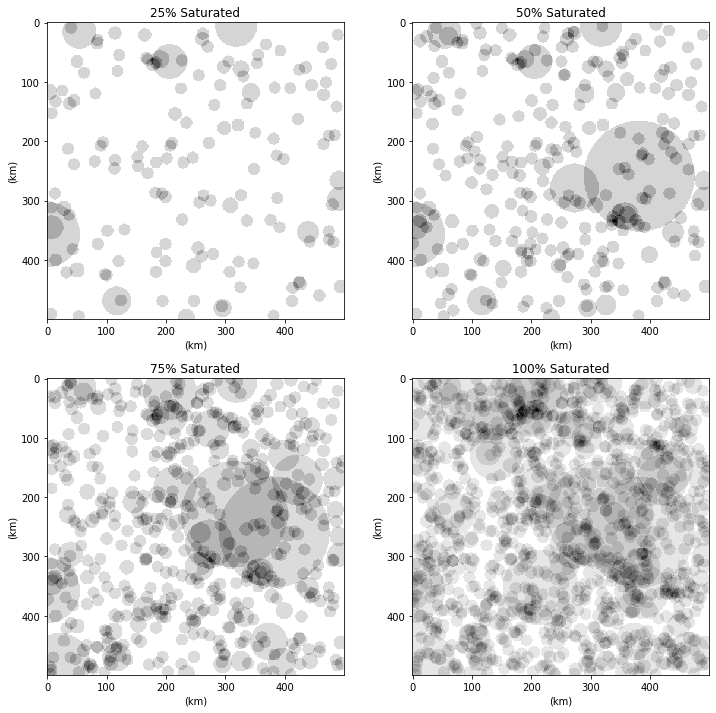

In [3]:
plotSimulation(sim)

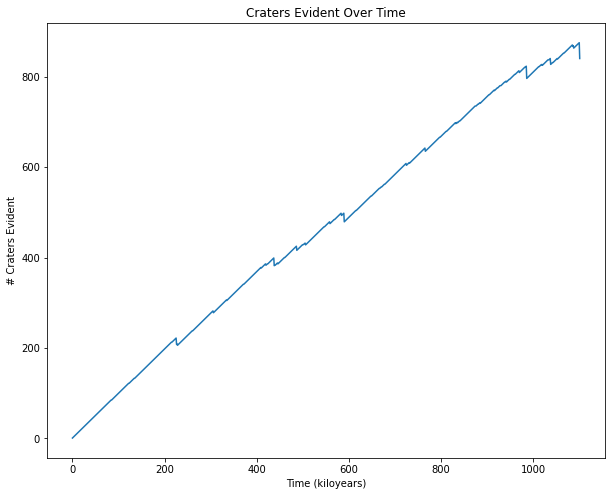

In [4]:
plotCratersEvident(sim)

In [5]:
print(f'Time to saturation: {sim.t*1000:,} years')

Time to saturation: 1,102,000 years


### Plot Description  
The saturation plots show the history of impacts on the surface up to the time it was saturated to the degree specified. The darker the sector is, the more impacts it was affected by.  
The craters evident plot shows how many craters were evident on the surface at the given point in time. The data appears in increments of 1000 years.  
  
### Narrative
Early on, things seem to be pretty standard with no overlap. Looking at the craters evident plot, it seems that one large crater came at about 200,000 years in and erased many smaller ones. I suspect that it would be the biggest one visible in the 50% saturation plot. From that point, the area becomes quite crowded, as is visible in the 75% saturation plot. As a result, the craters evident plot becomes turbulent as new craters become more likely to erase old ones. Towards the end, there appears to be a succession of medium to large impacts that erase many preexisting craters.

### Changed Assumption
I have modified my crater size function to cap the maximum crater radius at 20km instead of 100km to investigate how time-efficient large craters are at saturating an area despite their rarity

In [6]:
def getCraterSize2():
    size = (np.random.random()*5)**(-2)+10
    while size > 20:
        size = (np.random.random()*5)**(-2)+10
    
    return size

sim = CraterSimulation(getCraterSize2, 500, 90)
sim.start()

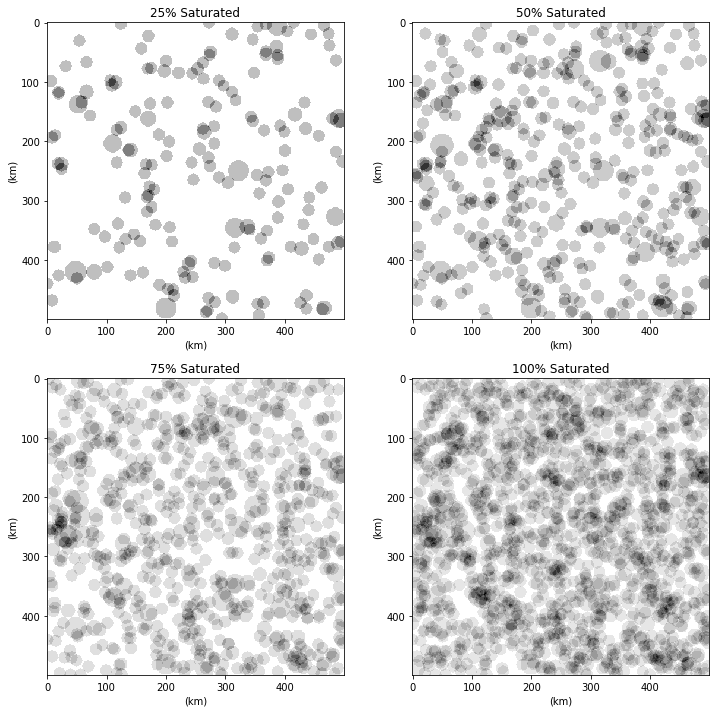

In [7]:
plotSimulation(sim)

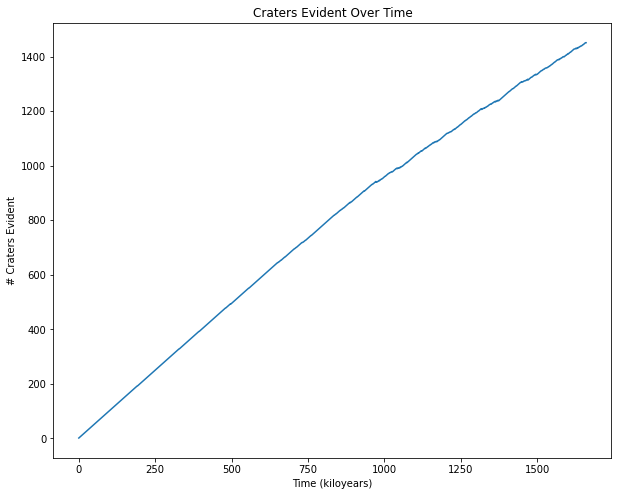

In [8]:
plotCratersEvident(sim)

In [9]:
print(f'Time to saturation: {sim.t*1000:,} years')

Time to saturation: 1,661,000 years


The most obvious change is that the size of craters is far more uniform. This heavily influenced the time it took to saturate the surface. This makes sense, because the average size of the craters is smaller. Something else to note is that, despite the rarity of large craters in the first simulation, they are far more efficient than the small craters because they fill in the gaps between small craters even if they land in a heavily bombarded area. The Craters Evident plot is also far less turbulent. This is due to the fact that most of the movement in the same plot from the previous simulation comes from larger craters covering up multiple small craters in one instance.